In [186]:
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn import manifold
from hdx.location.country import Country
%matplotlib inline
import numpy as np
import matplotlib.patches as mpatches
import networkx as nx

In [134]:
votes = pd.read_csv('votes.csv')
resol = pd.read_csv('resolutions.csv')
states = pd.read_csv('states.csv')

In [143]:
resol['year'] = resol.vote_date.apply(lambda x: str(x)[-4:])
states = states[states.year.notnull()]
all_states = states.state_name.unique()

In [147]:
veto_countries = ['United States of America', 'China', 'Russia', 'United Kingdom', 'France']
imp_countries = ['United States of America', 'Canada', 'Cuba', 'Peru', 'Brazil', 'Chile', 'Argentina',
       'United Kingdom', 'Ireland', 'Netherlands', 'Belgium', 'France', 'Monaco', 'Switzerland',
       'Spain', 'Portugal', 'German Federal Republic',
       'German Democratic Republic', 'Poland', 'Austria', 'Hungary',
       'Czech Republic', 'Slovakia', 'Italy', 
       'Greece', 'Russia',
       'Ukraine',
       'Finland', 'Sweden', 'Norway', 'Denmark',
       'South Africa',  'Libya', 'Iran',
       'Turkey', 'Iraq', 'Egypt', 'Syria', 'Lebanon', 'Jordan', 'Israel',
       'Saudi Arabia', 'Qatar', 'United Arab Emirates', 'Oman',
       'Afghanistan',
        'China', 'Mongolia', 'Taiwan',
       'North Korea', 'South Korea', 'Japan', 'India', 
       'Pakistan', 'Bangladesh','Sri Lanka',
       'Singapore', 'Philippines', 'Indonesia',
       'Australia', 'New Zealand']

In [4]:
# count for all countries by year
year_country_count ={}
for i in range(len(states)):
    curr = states.iloc[i]
    year_country_count[str(int(curr['year']))+"_"+str(curr['state_name'])] = float(curr.yes_votes)+float(curr.no_votes)

In [215]:
# shared votes
shared_votes = {}
for year in resol.year.unique():
    curr_year = resol[resol.year == year] 
    for vote in curr_year.vote_id:
        curr_votes = votes[votes.vote_id == vote]
        yes_votes = curr_votes[curr_votes.vote==1]
        no_votes = curr_votes[curr_votes.vote==3]
        for v in [yes_votes, no_votes]:
            comb = combinations(v.state_name, 2)
            for c1, c2 in list(comb):
                try:
                    shared_votes[str(year)+"_"+c1+"_"+c2] += 1
                except:
                    shared_votes[str(year)+"_"+c1+"_"+c2] = 1

In [221]:
shared_votes_df = pd.DataFrame({'year_countries':shared_votes.keys(), 'count':shared_votes.values()})
shared_votes_df.to_csv('shared_votes.csv')

In [161]:
region=[]
for s in all_states:
        a = Country.get_iso3_country_code_fuzzy(s)
        try:
            region.append(Country.get_country_info_from_iso3(a[0])['Region Name'])
        except:
            region.append('Others')

In [206]:
def region_to_color(x):
    if x =='Africa':
        return 'black'
    elif x=='Americas':
        return 'blue'
    elif x=='Asia':
        return 'orange'
    elif x=='Europe':
        return 'red'
    elif x=='Oceania':
        return 'green'
    else:
        return 'grey'

In [6]:
affility_score = {}
for s_vote in shared_votes:
    year, c1, c2 = s_vote.split("_")
    try:
        n = year_country_count[year+"_"+c1]
        m = year_country_count[year+"_"+c2]
        k = shared_votes[year+"_"+c1+"_"+c2]
        year = int(year)
        if year in affility_score:
            affility_score[year][c1+"_"+c2] = (k*1.0/n + k*1.0/m)/2
        else:
            affility_score[year] = {}
            affility_score[year][c1+"_"+c2] = (k*1.0/n + k*1.0/m)/2
    except KeyError:
        continue

In [226]:
c1 = []
c2 = []
for year in affility_score:
    for Cs in affility_score[year]:
        c1.append(str(year)+"_"+Cs)
        c2.append(affility_score[year][Cs])

In [229]:
score_df = pd.DataFrame({'year_countries':c1, 'affinity':c2})
score_df.to_csv('score.csv')

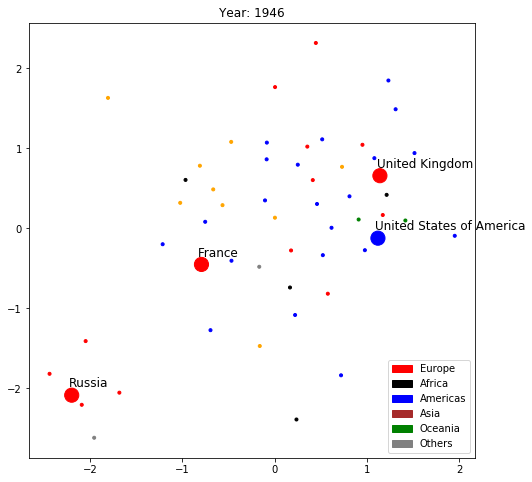

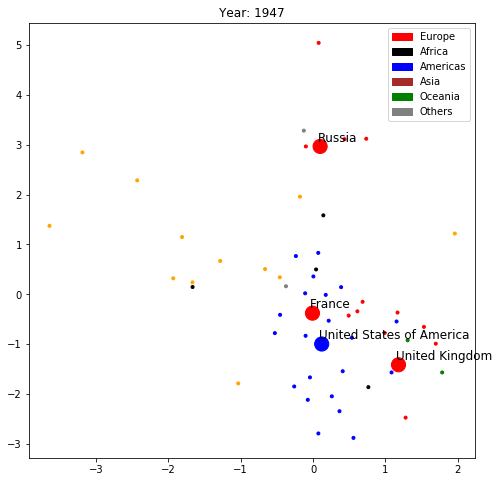

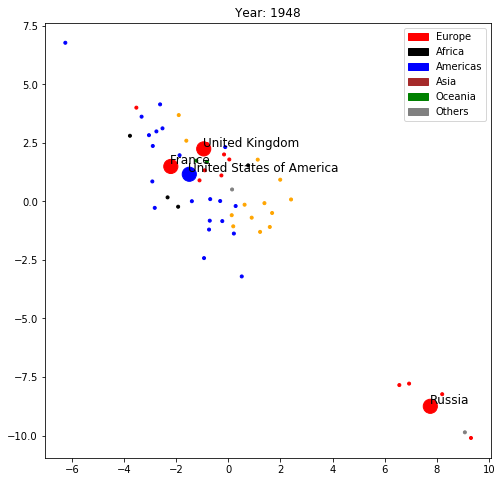

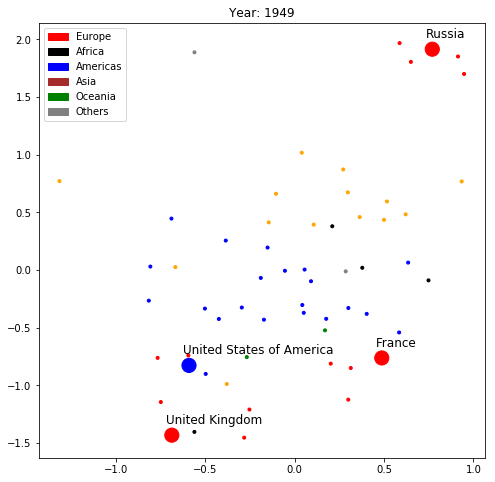

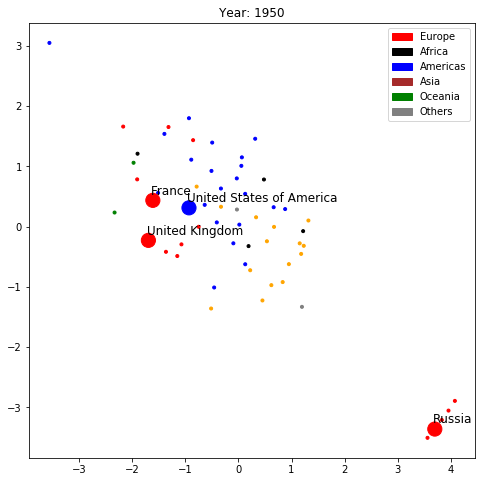

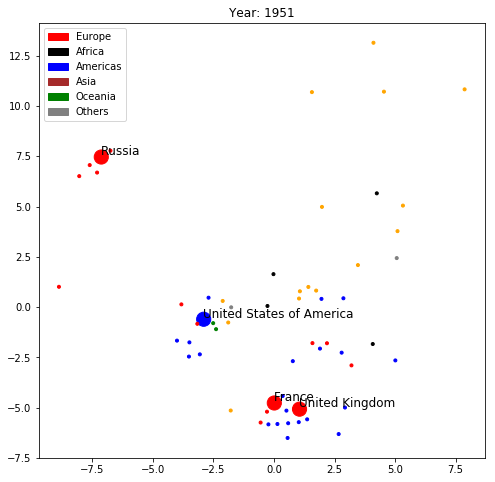

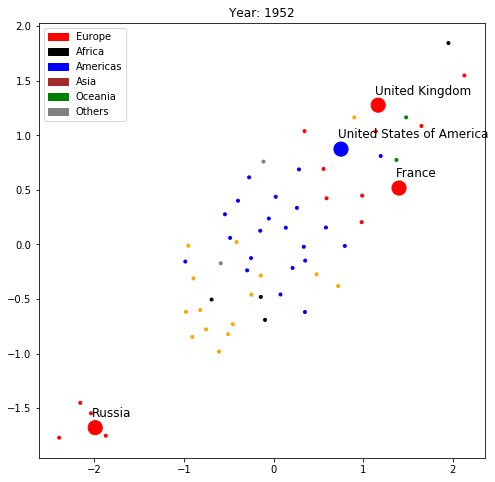

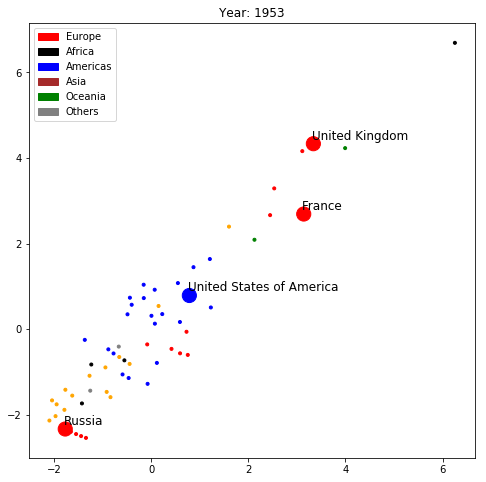

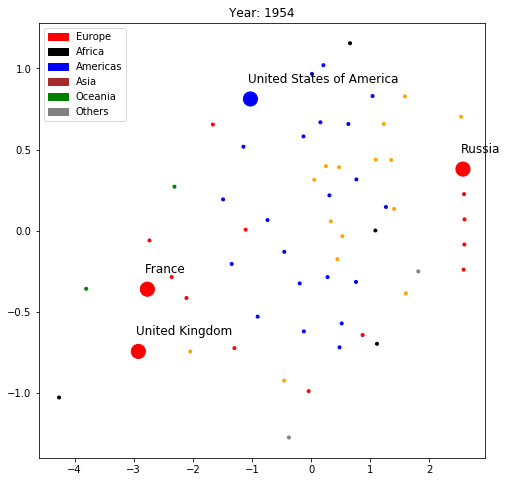

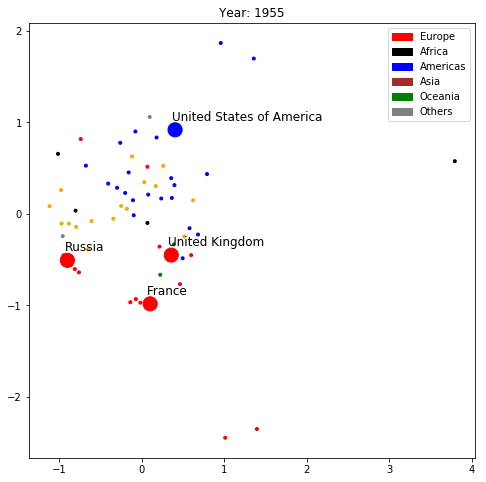

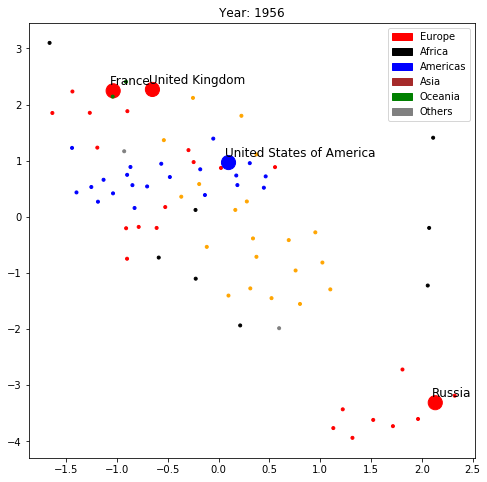

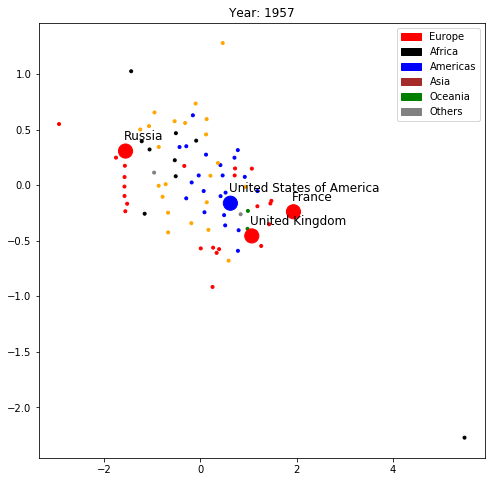

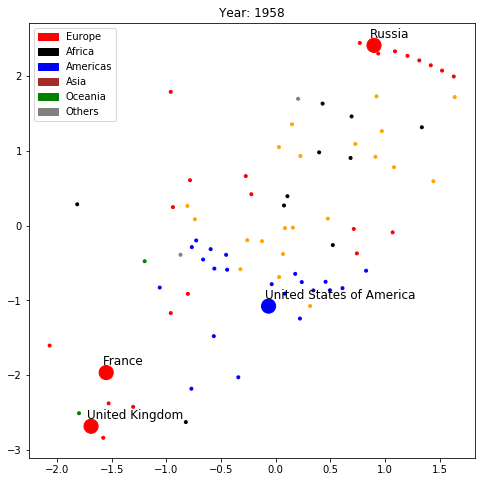

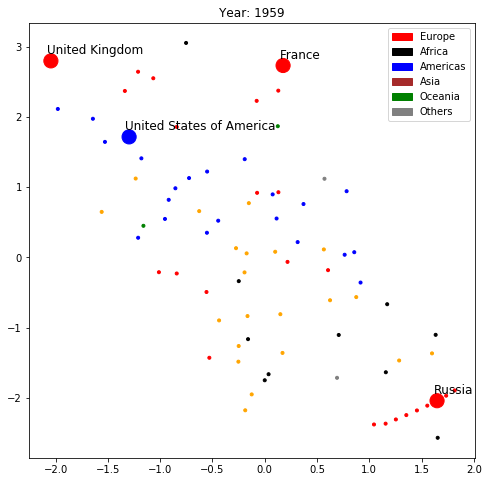

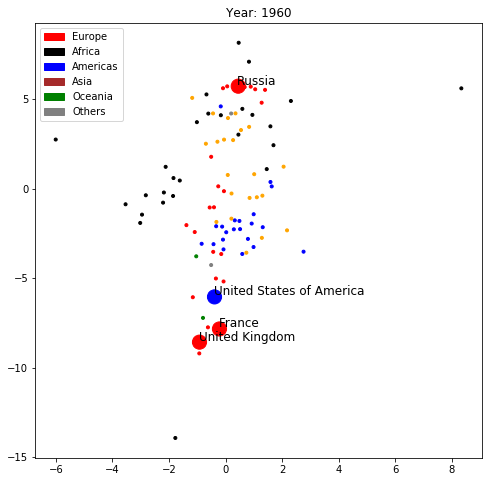

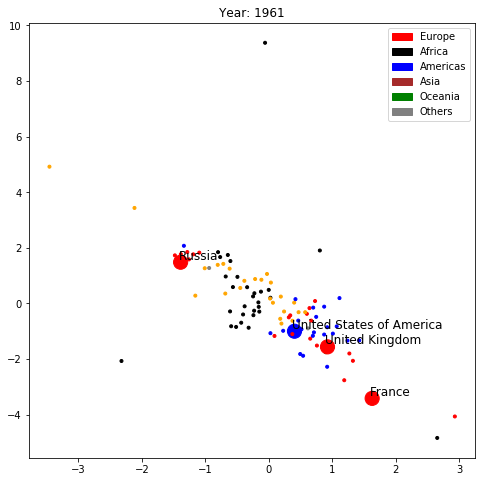

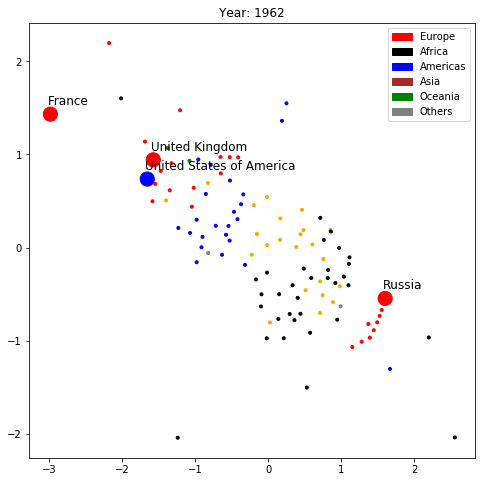

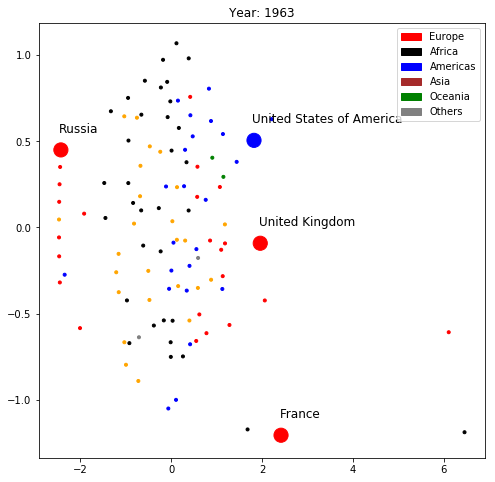

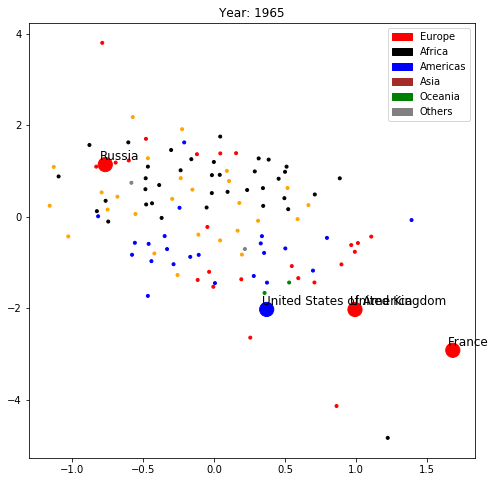

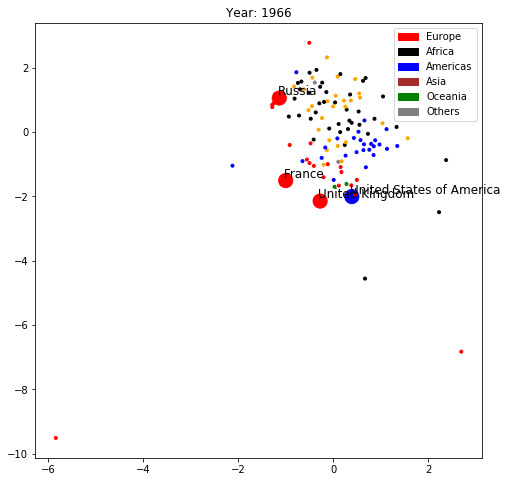

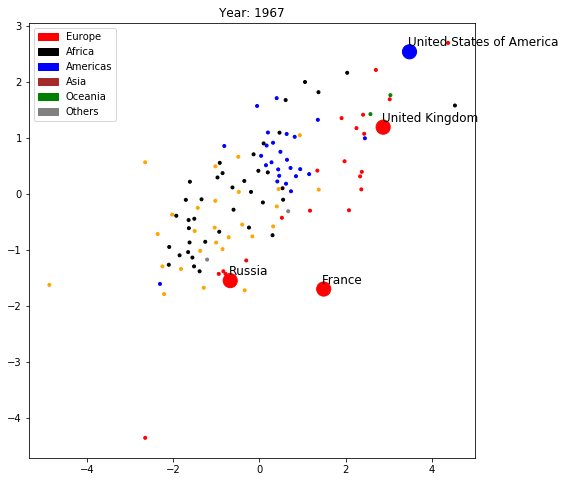

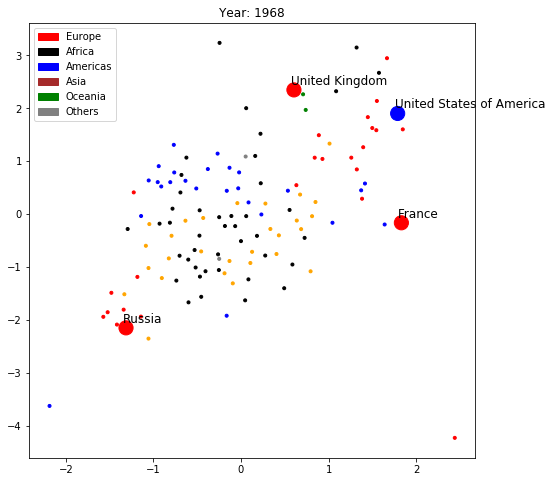

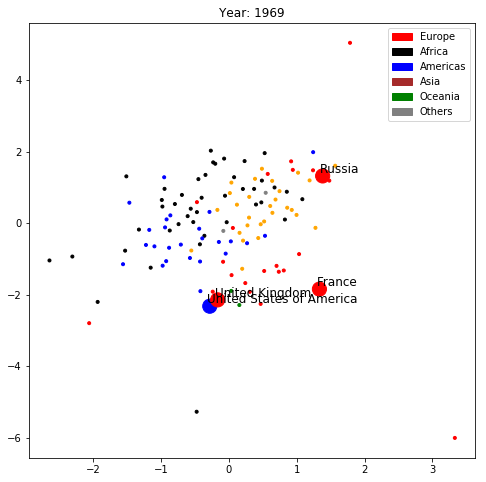

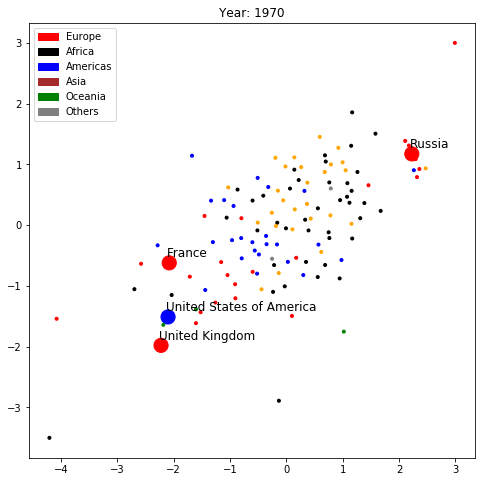

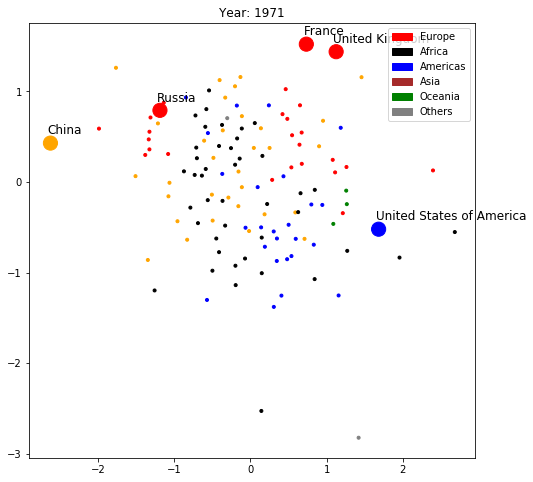

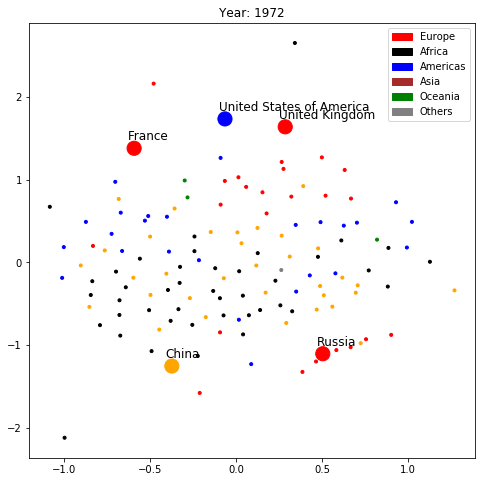

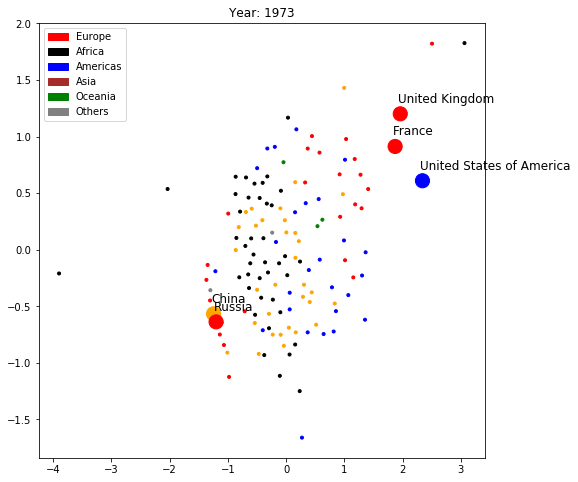

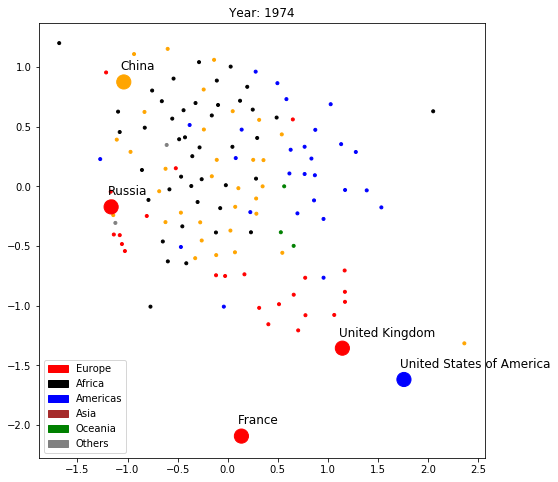

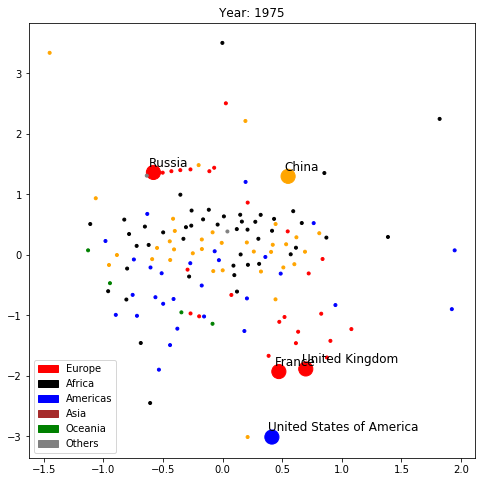

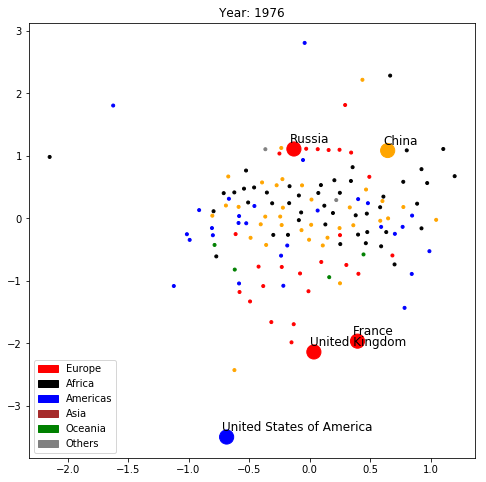

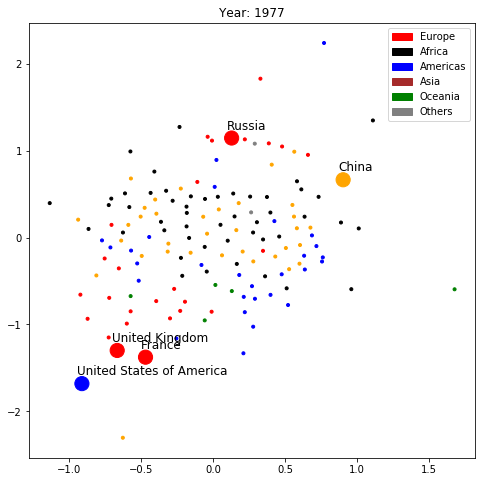

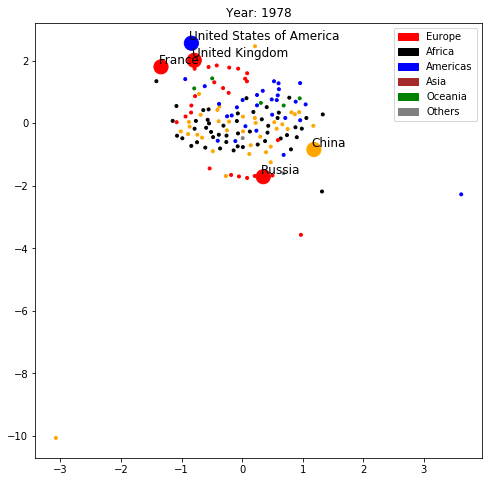

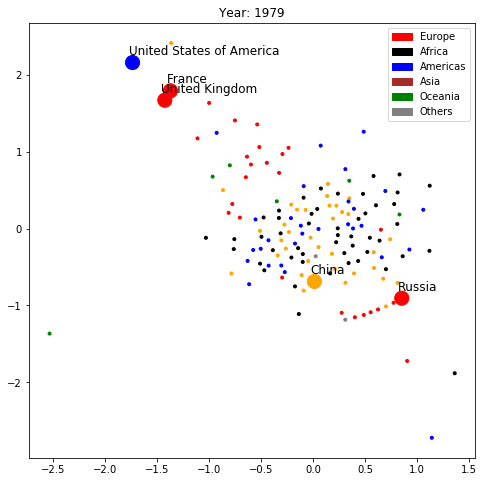

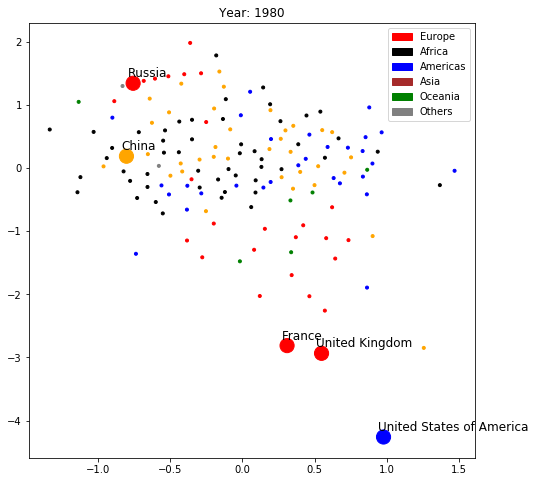

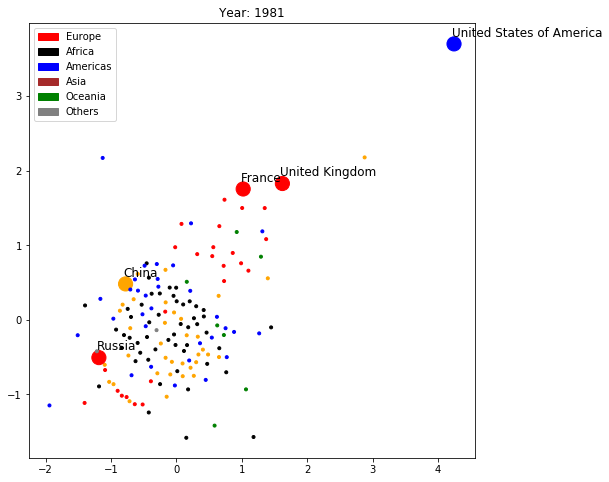

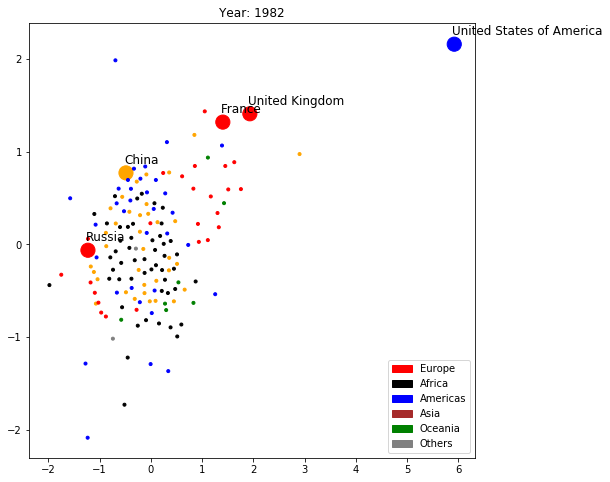

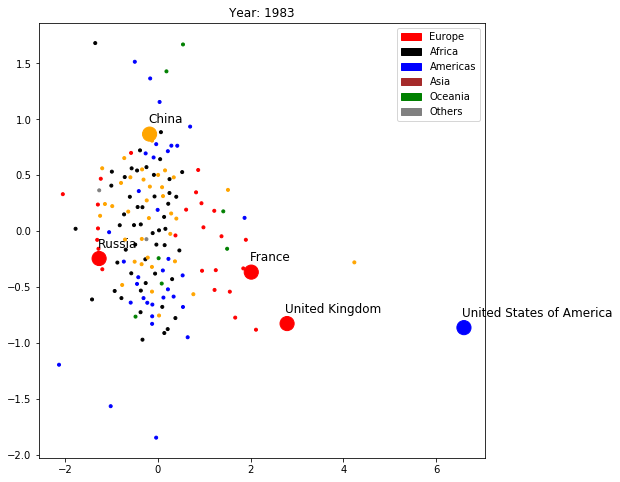

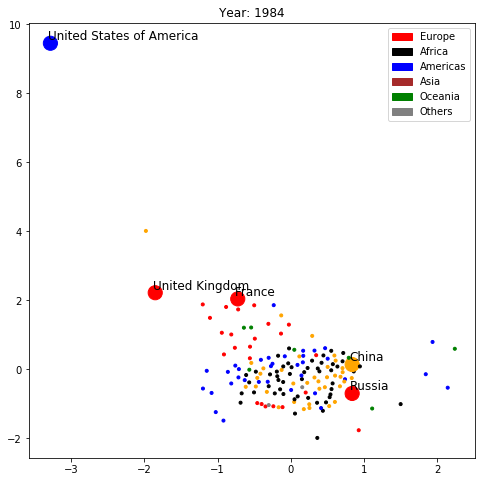

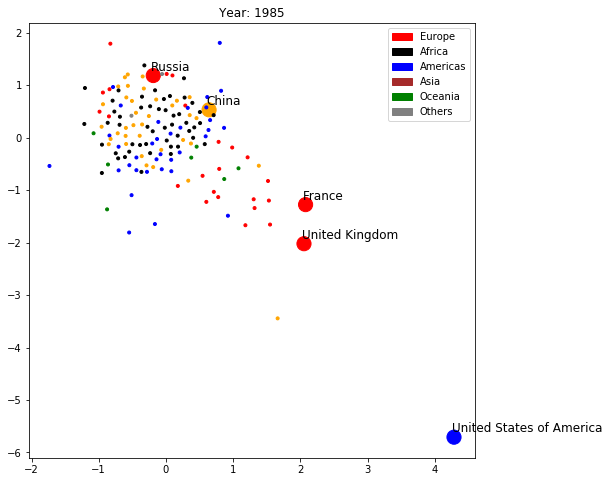

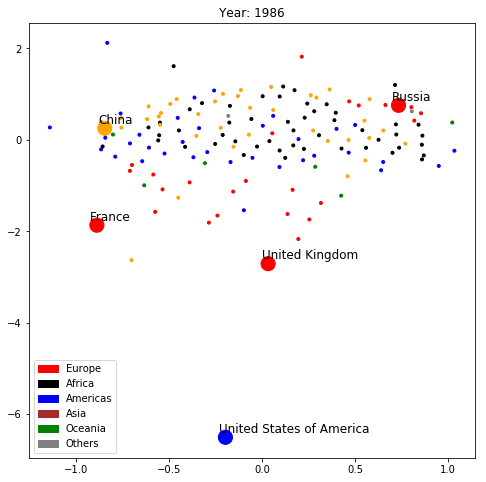

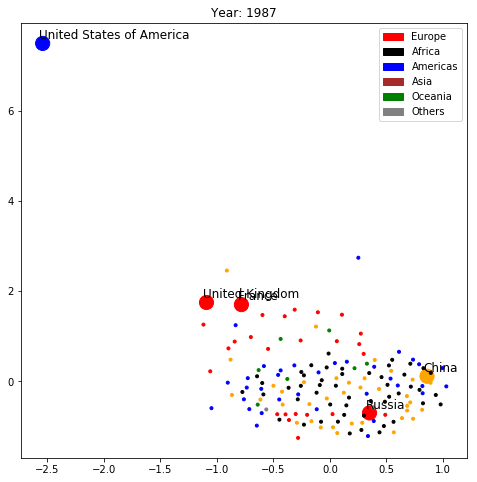

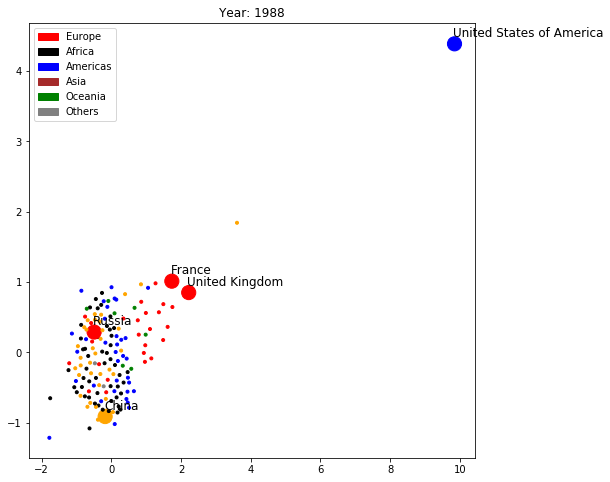

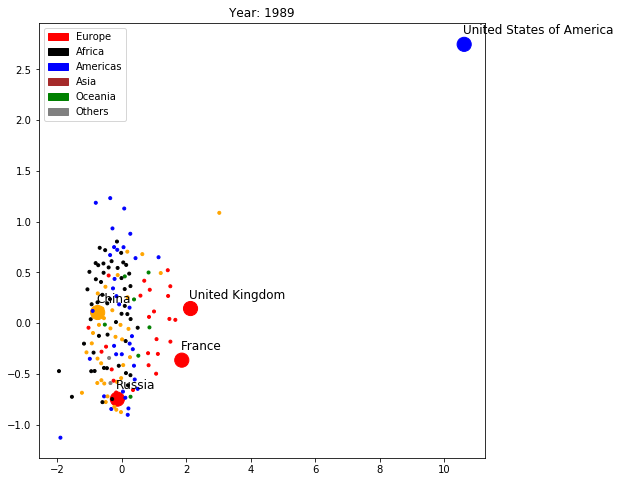

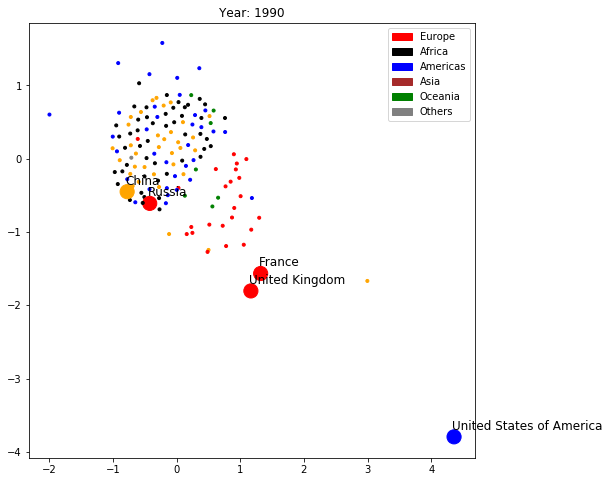

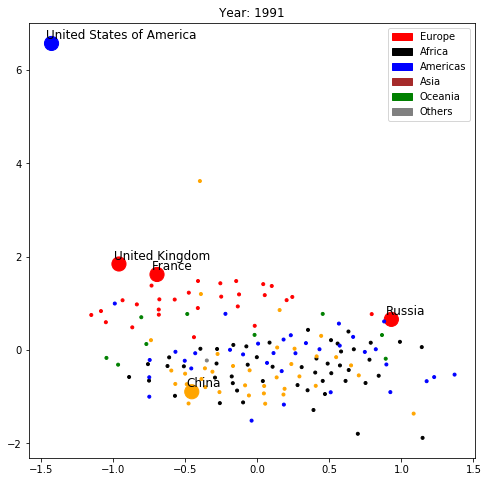

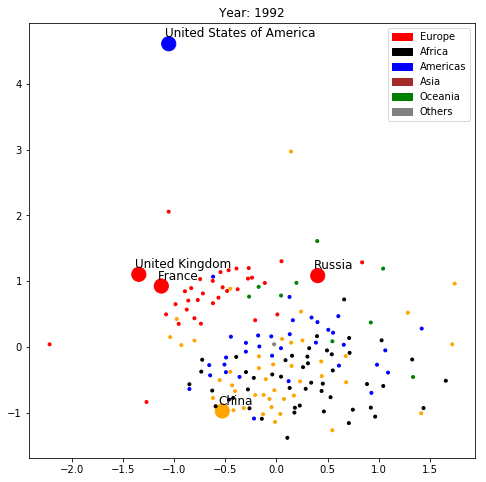

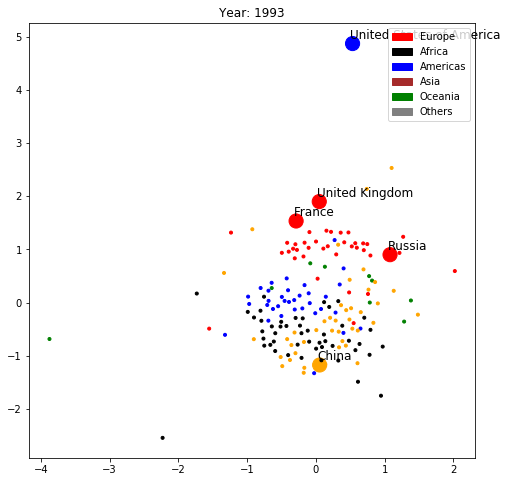

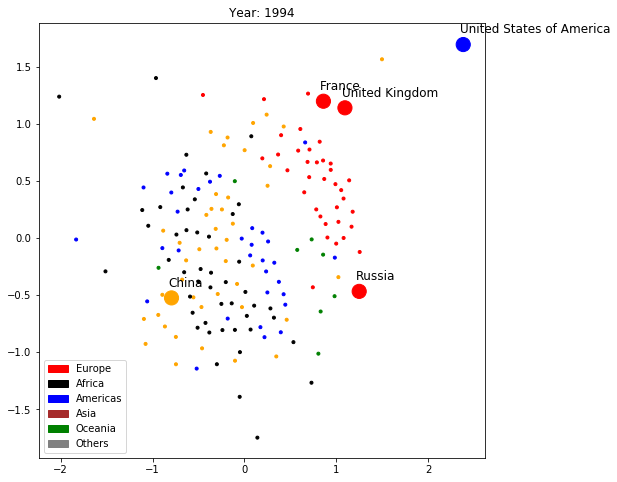

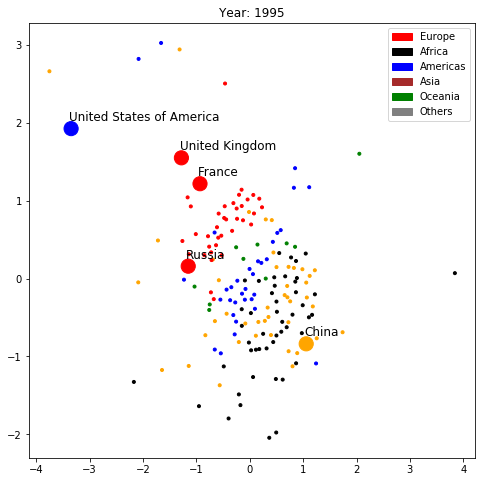

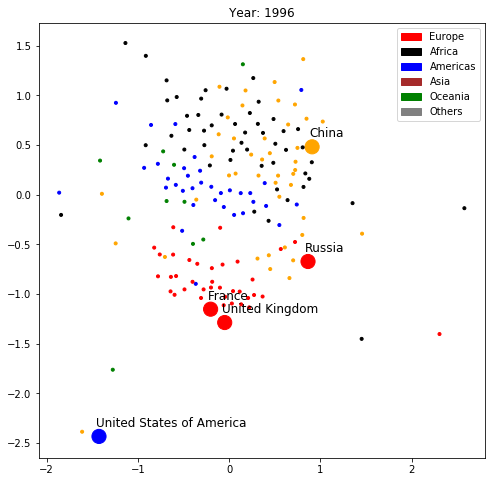

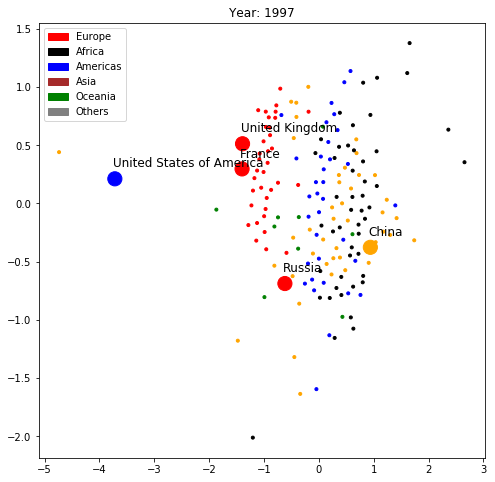

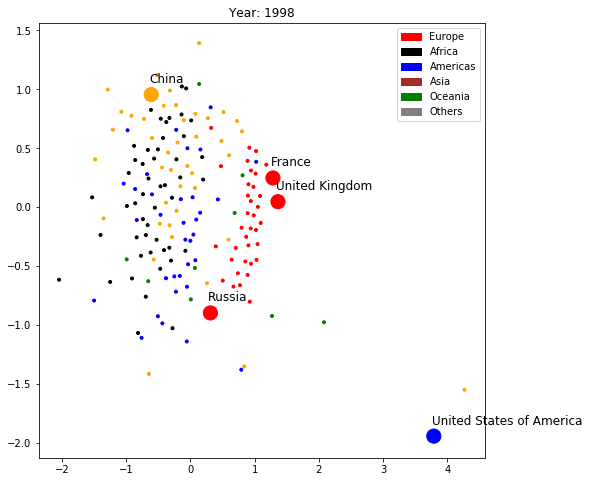

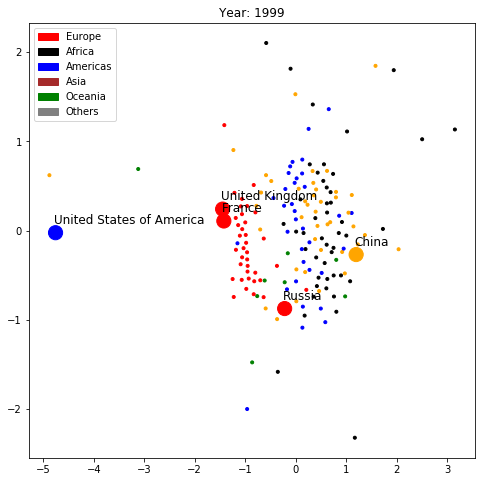

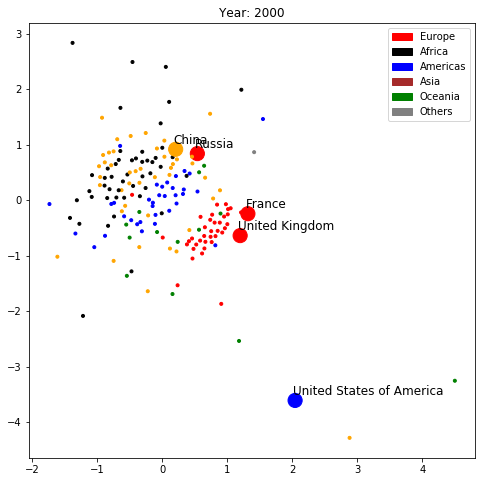

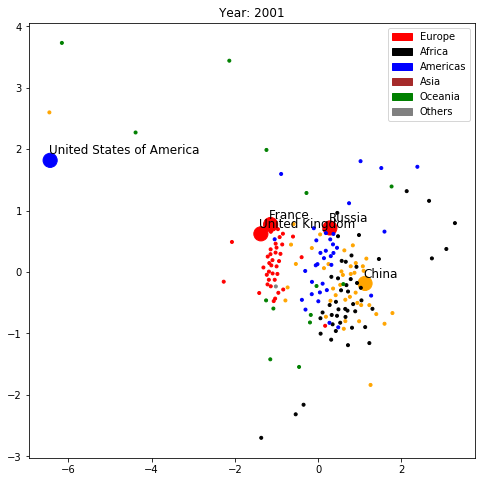

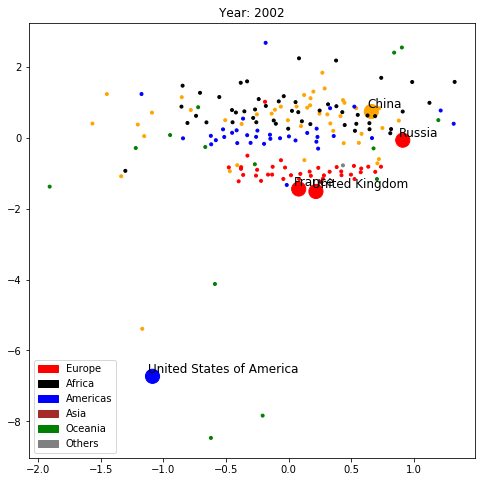

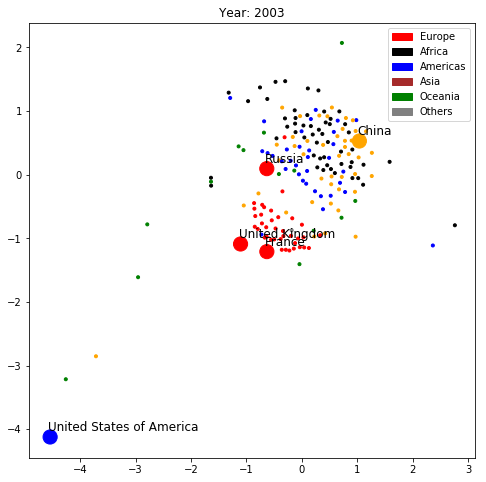

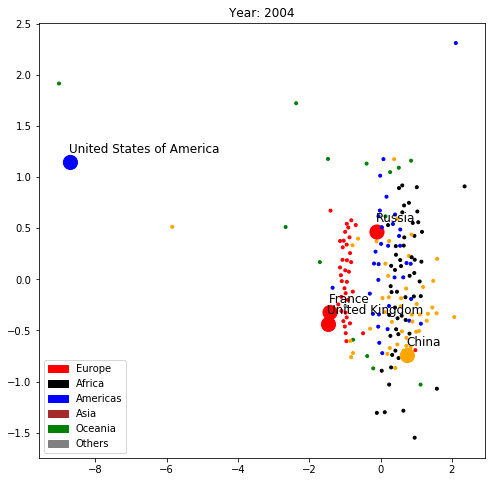

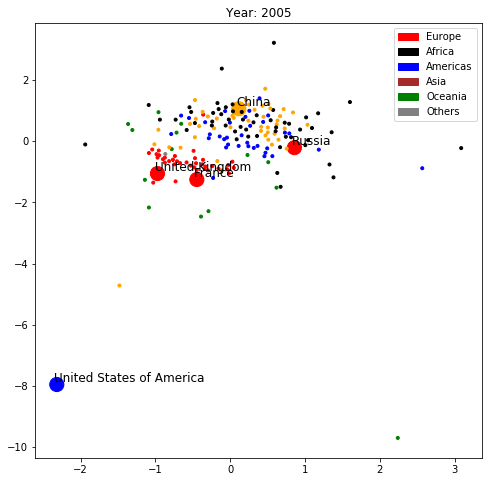

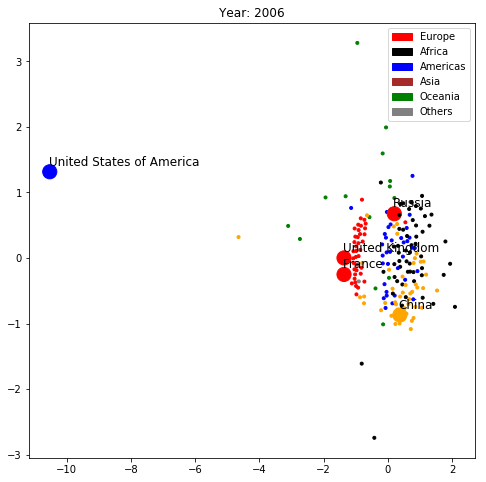

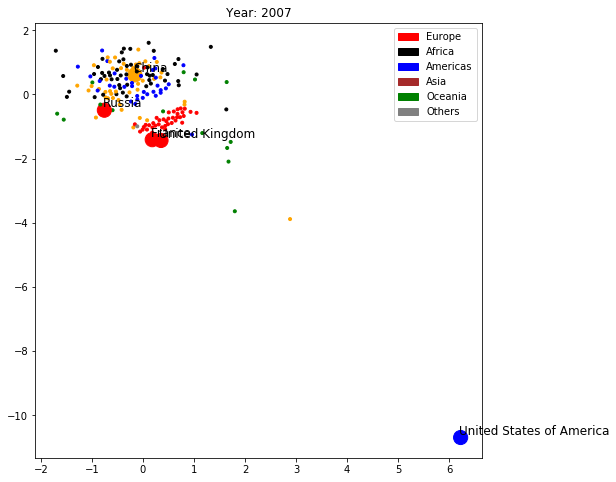

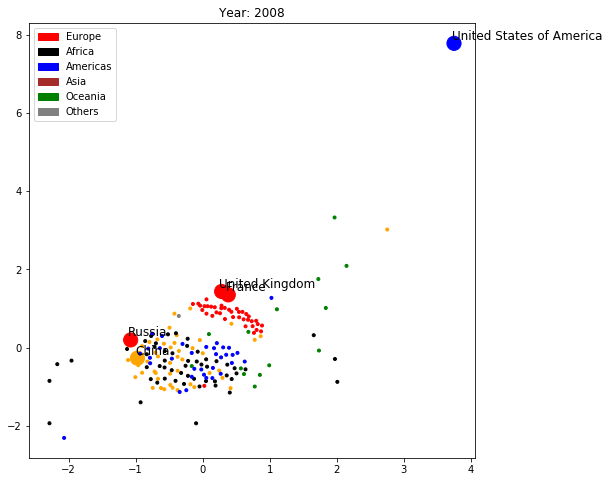

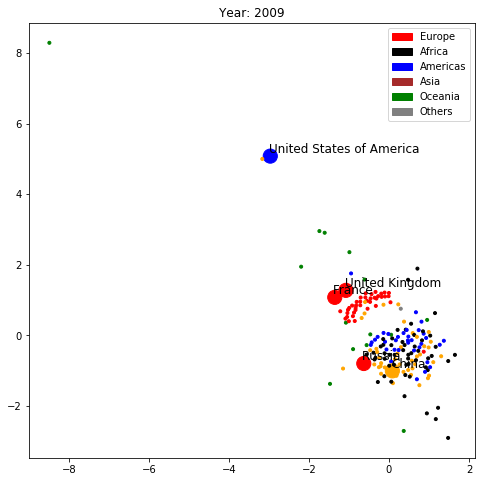

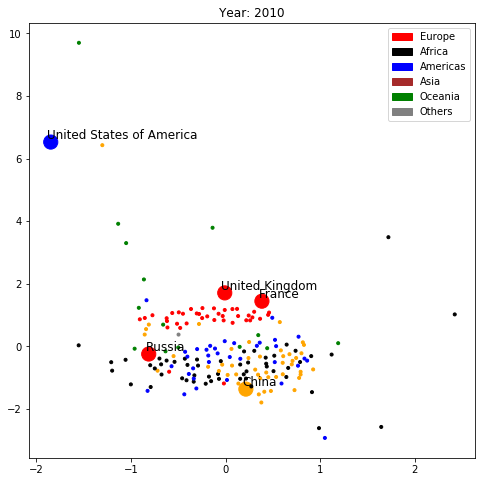

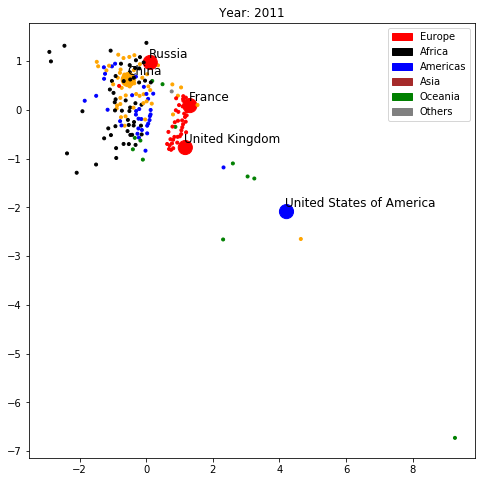

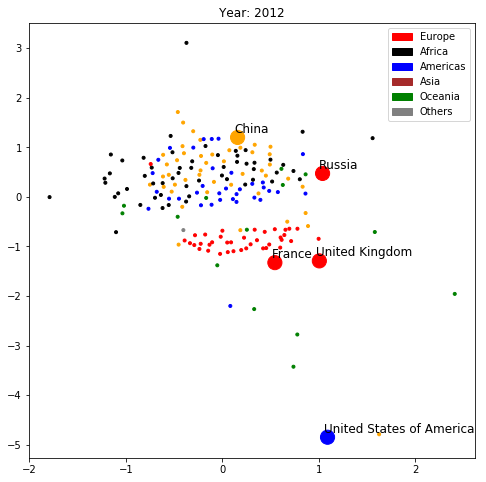

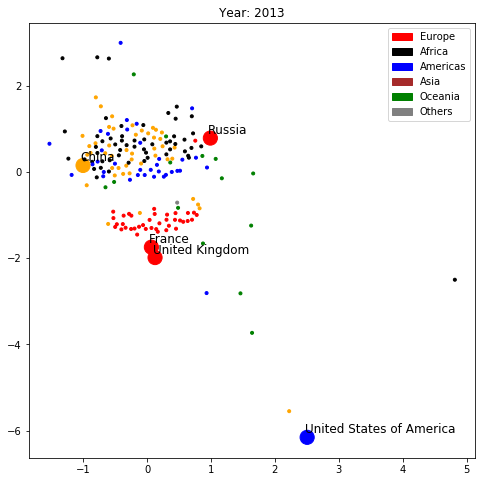

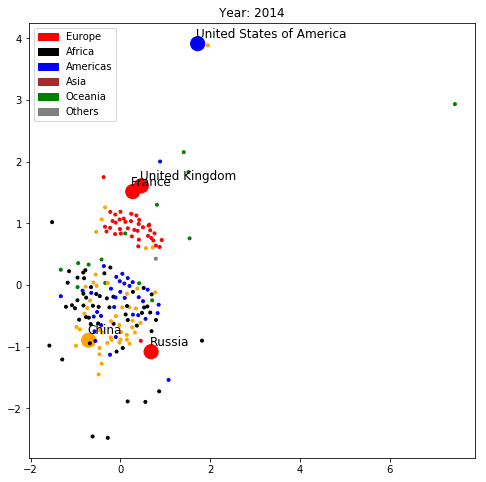

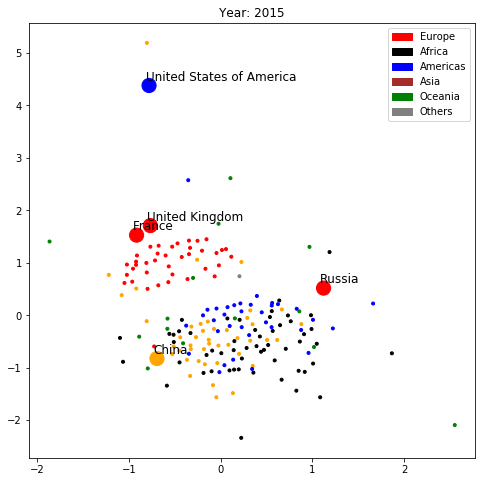

In [237]:
patches = []
patches.append(mpatches.Patch(color='red', label='Europe'))
patches.append(mpatches.Patch(color='black', label='Africa'))
patches.append(mpatches.Patch(color='blue', label='Americas'))
patches.append(mpatches.Patch(color='brown', label='Asia'))
patches.append(mpatches.Patch(color='green', label='Oceania'))
patches.append(mpatches.Patch(color='grey', label='Others'))

for year in affility_score.keys()[:]:
    curr_year_dict = affility_score[year]
    states = set()
    for Cs in curr_year_dict.keys():
        c1, c2 = Cs.split("_")
        states.add(c1)
        states.add(c2)
    states_list = list(states)
    affility_matrix = [[0 for x in range(len(states_list))] for y in range(len(states_list))]
    for Cs in curr_year_dict.keys():
        c1, c2 = Cs.split("_")
        c1_loc, c2_loc = list(states_list).index(c1), list(states_list).index(c2)
        affility_matrix[c1_loc][c2_loc] = 1/curr_year_dict[Cs]
        affility_matrix[c2_loc][c1_loc] = 1/curr_year_dict[Cs]
    
    #position
    mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-3, random_state=1,
                   dissimilarity="precomputed", n_jobs=1, metric = True)
    pos = mds.fit(affility_matrix).embedding_
    pos_x = [x[0] for x in pos]
    pos_y = [x[1] for x in pos]
    plt.figure(figsize=(8,8))
    
    # region
    region = []
    for s in states_list:
        a = Country.get_iso3_country_code_fuzzy(s)
        try:
            region.append(Country.get_country_info_from_iso3(a[0])['Region Name'])
        except:
            region.append('Others')
    
    colors = [region_to_color(x) for x in region]
    
    size = [9 for x in range(len(pos_x))]
    for c in veto_countries:
        try:
            size[states_list.index(c)] = 200
        except ValueError:
            continue
        
    plt.figure(figsize=(8,8))
    plt.scatter(pos_x, pos_y, s = size, color = colors, label = region)
    #for i in range(len(states_list)):
    for s in veto_countries:
        try:
            i = states_list.index(s)
            plt.text(pos_x[i]-0.035, pos_y[i]+0.1, s, fontsize = 12)
        except ValueError:
            continue
#        if states_list[i] in veto_countries:
#            plt.text(pos_x[i]-0.035, pos_y[i]+0.1, states_list[i], fontsize = 12)
    plt.legend(handles=patches)
    plt.title('Year: {}'.format(year))
    plt.show()